#**Netflix Movies and Shows Dataset -- Team Theta**





### Questions
##### 1. Which countries produce the most content on Netflix?  
##### 2. How has the number of movies released changed over the years?
##### 3. What are the most frequently occurring genres on Netflix?
##### 4. Based on the description what tv show/movie is most similar?

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.api as sm
import os
import math
import string
import ast
import random
!pip install clean-text
%matplotlib inline
#ML Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
#  NLTK Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('titles.csv')
df.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.9 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=6c7fbaf979a459f2eb6955ca27db3b62303efed9a0297452f18639b2cf92c907
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji


FileNotFoundError: ignored

#Descriptive Analysis

In [ ]:
# Info on data types, column names, counts, etc.
df.info()

NameError: ignored

In [ ]:
# shape of the original df
df.shape

(5850, 15)

In [ ]:
# the df described
df.describe()

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
count,5850.000000,5850.000000,2106.000000,5368.000000,5.352000e+03,5759.000000,5539.000000
mean,2016.417094,76.888889,2.162868,6.510861,2.343938e+04,22.637925,6.829175
std,6.937726,39.002509,2.689041,1.163826,9.582047e+04,81.680263,1.170391
min,1945.000000,0.000000,1.000000,1.500000,5.000000e+00,0.009442,0.500000
25%,2016.000000,44.000000,1.000000,5.800000,5.167500e+02,2.728500,6.100000
50%,2018.000000,83.000000,1.000000,6.600000,2.233500e+03,6.821000,6.900000
75%,2020.000000,104.000000,2.000000,7.300000,9.494000e+03,16.590000,7.537500
max,2022.000000,240.000000,42.000000,9.600000,2.294231e+06,2274.044000,10.000000


In [ ]:
# Correlation between features
corr =  df.corr()
corr.style.background_gradient(cmap='Reds')

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
release_year,1.000000,-0.173551,-0.504407,-0.129380,-0.208815,0.043244,0.032073
runtime,-0.173551,1.000000,-0.139642,-0.148068,0.139760,0.002545,-0.277454
seasons,-0.504407,-0.139642,1.000000,0.106806,0.206079,0.168051,0.044023
imdb_score,-0.129380,-0.148068,0.106806,1.000000,0.190661,0.017675,0.570754
imdb_votes,-0.208815,0.139760,0.206079,0.190661,1.000000,0.209763,0.112960
tmdb_popularity,0.043244,0.002545,0.168051,0.017675,0.209763,1.000000,0.071894
tmdb_score,0.032073,-0.277454,0.044023,0.570754,0.112960,0.071894,1.000000


#Data Cleaning
##### A. Removing rows with imcompete datas (IE, missing votes/ ratings)
##### B. Removing columns that wont be utilized in order to make data set easier to read(runtime, age_cert, seasons, etc)
##### C. Reducing "genres" and "production_countries" to one tag.

In [ ]:
# Dropping columns we do not need first
# columns = ID, Age, Runtime, Seasons, IMDB_ID)
df = df.drop(columns=["id", "age_certification","runtime", "seasons", "imdb_id"])

NameError: ignored

In [ ]:
# Checking for duplicate values, then removing them.
dup_df = df.duplicated().any()
print("Any duplicate values?", dup_df) # returns False
# Checking for missing values, then removing them.
print("Any missing value?", df.isnull().values.any()) # returns True
df.dropna(axis = 0, inplace= True)
print(df.isnull().sum())

In [ ]:
# Filtering dataset to movies that were released after 2010.
# The purpose of this is to reduce dataset to more relevant information
#df = df[df['release_year'] > 2010]

In [ ]:
# Cleaning the production_countries for readability
# Some title's have multiple production countries
df['production_countries'] = df['production_countries'].str.replace(r"[", '').str.replace(r"'", '').str.replace(r"]", '')
df['production_countries_2'] = df['production_countries'].str.split(',').str[0]
df.production_countries_2 = df.production_countries_2.replace('', np.nan)
#Dropping orginal production_countries column, renaming the second one
df.drop('production_countries', axis=1, inplace=True)
df.rename(columns={'production_countries_2': 'production_countries'}, inplace=True)
df.head()

Pre-processing/Cleaning for Genre analysis below

In [ ]:
df['genres'].value_counts()
# Due to the structure of the data, the method cannot parse the values in the most fitting manner.
# We must parse the genres ourselves.

NameError: ignored

In [ ]:
# Modifying the get_genres function to transform the original columns
# We will only use the first element of each value in the genres column
# The first genre seems to be the one that represents the movie/show the most
def transform_genres(row):
parsed = (str(row)[1:-1]).split(",")
genres = {}
for i in range(len(parsed)):
genre = parsed[i].strip()[1:-1]
if genre != '':
if genre not in genres.keys():
genres[genre] = 0
genres[genre] += 1
return max(genres, key=genres.get) if genres else 'none'
# Preforming the transformation
df['genres_transformed'] = df['genres'].map(transform_genres)
df['genres_transformed'].value_counts()

In [ ]:
# Parse genre column and function
genres = {}
def get_genres(row):
parsed = (str(row)[1:-1]).split(",")
for i in range(len(parsed)):
parsed[i] = parsed[i].strip()
parsed[i] = parsed[i][1:-1]
for i in parsed:
if i not in genres.keys():
genres[i] = 0
continue
genres[i] += 1
return row
df['genres'] = df['genres'].map(get_genres)
genres

In [ ]:
#Dropping orginal genres column, renaming the transformed one
df.drop('genres', axis=1, inplace=True)
df.rename(columns={'genres_transformed': 'genres'}, inplace=True)
df.head()

#Exploratory Data Analysis - EDA

<Figure size 1500x1000 with 0 Axes>

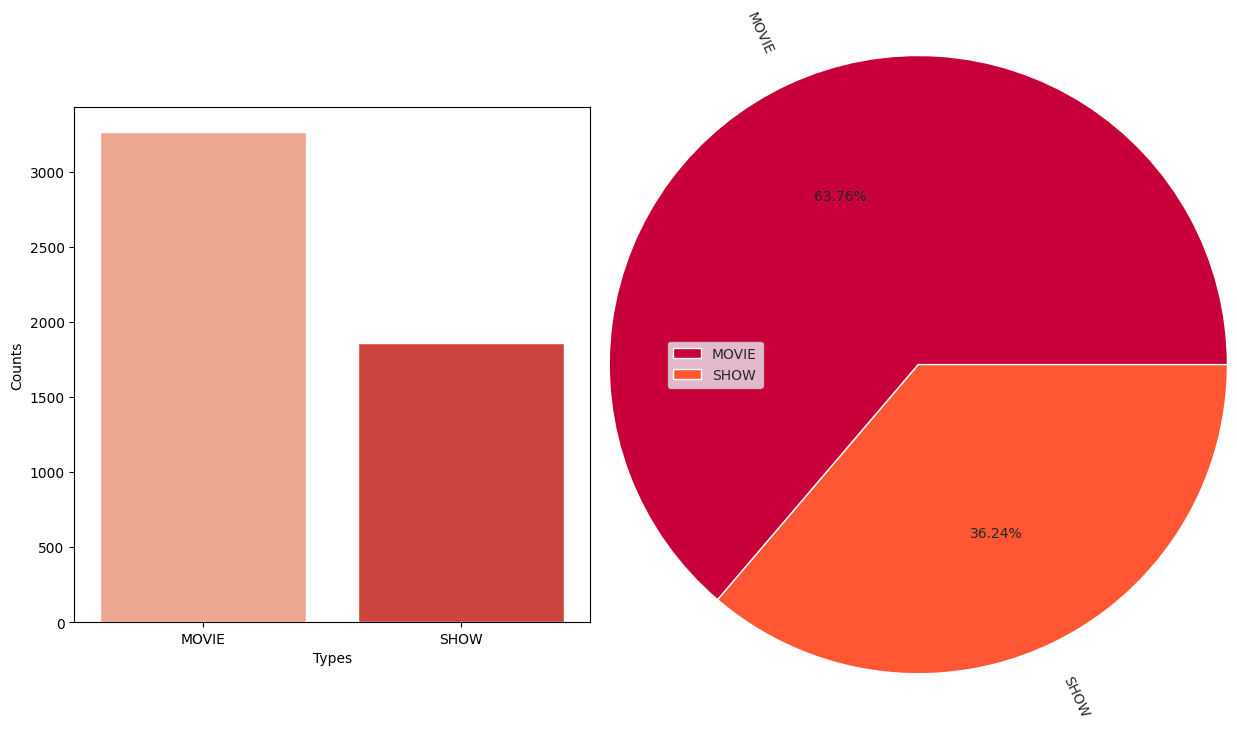

In [ ]:
# Pie/Bar Charts of the dataset types
types = df.groupby('type').size().reset_index().rename(columns = {0:'counts'})
types
def figure_size():
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)
font = {'family' : 'normal','size'   : 13}
figure_size()
langs= types.type
fig, axes = plt.subplots(1,2, figsize=(12,6))
plt.tight_layout(pad=2)
sns.set_style("darkgrid")
a1=sns.barplot(x = types.type,y = types.counts,ax=axes[0], palette='Reds');
a1.set(xlabel='Types', ylabel='Counts')
plt.pie(types.counts,autopct='%1.2f%%',labels = langs,radius=1.5,labeldistance=1.1 ,   rotatelabels=True, colors=['#C70039', '#FF5733'])
plt.legend()
plt.show()

In [ ]:
movie_df = df[df['type'] == 'MOVIE']
show_df = df[df['type'] == 'SHOW']
movie_count = movie_df['title'].count()
show_count = show_df['title'].count()
print(movie_count)
print(show_count)

3270
1859


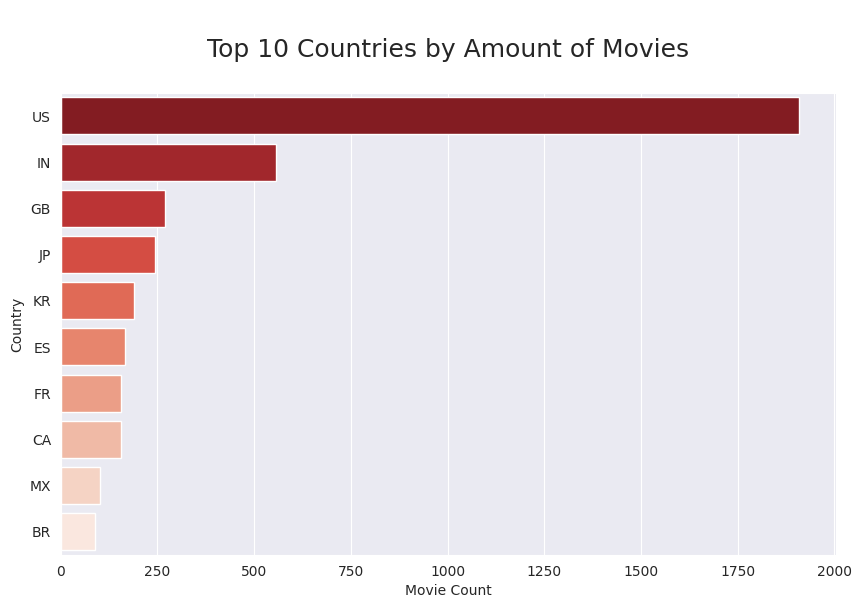

In [ ]:
# A Bar chart that answer's the question: Which country produces the most content on Netflix?
df_country = pd.DataFrame(df.production_countries.value_counts()).head(10)
order = df_country.index
plt.figure(figsize=(10,6))
plt.title('\nTop 10 Countries by Amount of Movies\n', fontsize=18)
sns.countplot(y=df.production_countries,  , order=order)
plt.xlabel('Movie Count')
plt.ylabel('Country')
plt.show()
#Analysis: Countries of movie production

In [ ]:
top_10_countries = df['production_countries'].value_counts().head(10)
top_10_countries = top_10_countries.sort_values(ascending=False)
top_10_countries = top_10_countries.index.tolist()
df_top_10 = df[df['production_countries'].isin(top_10_countries)]
avg_scores_by_country = df_top_10.groupby('production_countries')['imdb_score'].mean()
avg_scores_by_country = avg_scores_by_country.sort_values(ascending=False)
plt.figure(figsize=(12,8))
sns.set_palette('Reds_r')
sns.barplot(avg_scores_by_country.index, avg_scores_by_country.values, palette='Reds_r')
plt.title('Average IMDB Score by Top 10 Producing Countries')
plt.xlabel('Country')
sns.set_palette('Reds_r')
plt.xticks(rotation=45)
plt.ylabel('Average IMDB Score')
plt.show()

NameError: ignored

In [ ]:
US_df = df[df['production_countries'] == 'US']
IN_df = df[df['production_countries'] == 'IN']
GB_df = df[df['production_countries'] == 'GB']
US_count = US_df['title'].count()
IN_count = IN_df['title'].count()
GB_count = GB_df['title'].count()
print(US_count)
print(IN_count)
print(GB_count)

1908
556
269


<Axes: xlabel='count', ylabel='genres'>

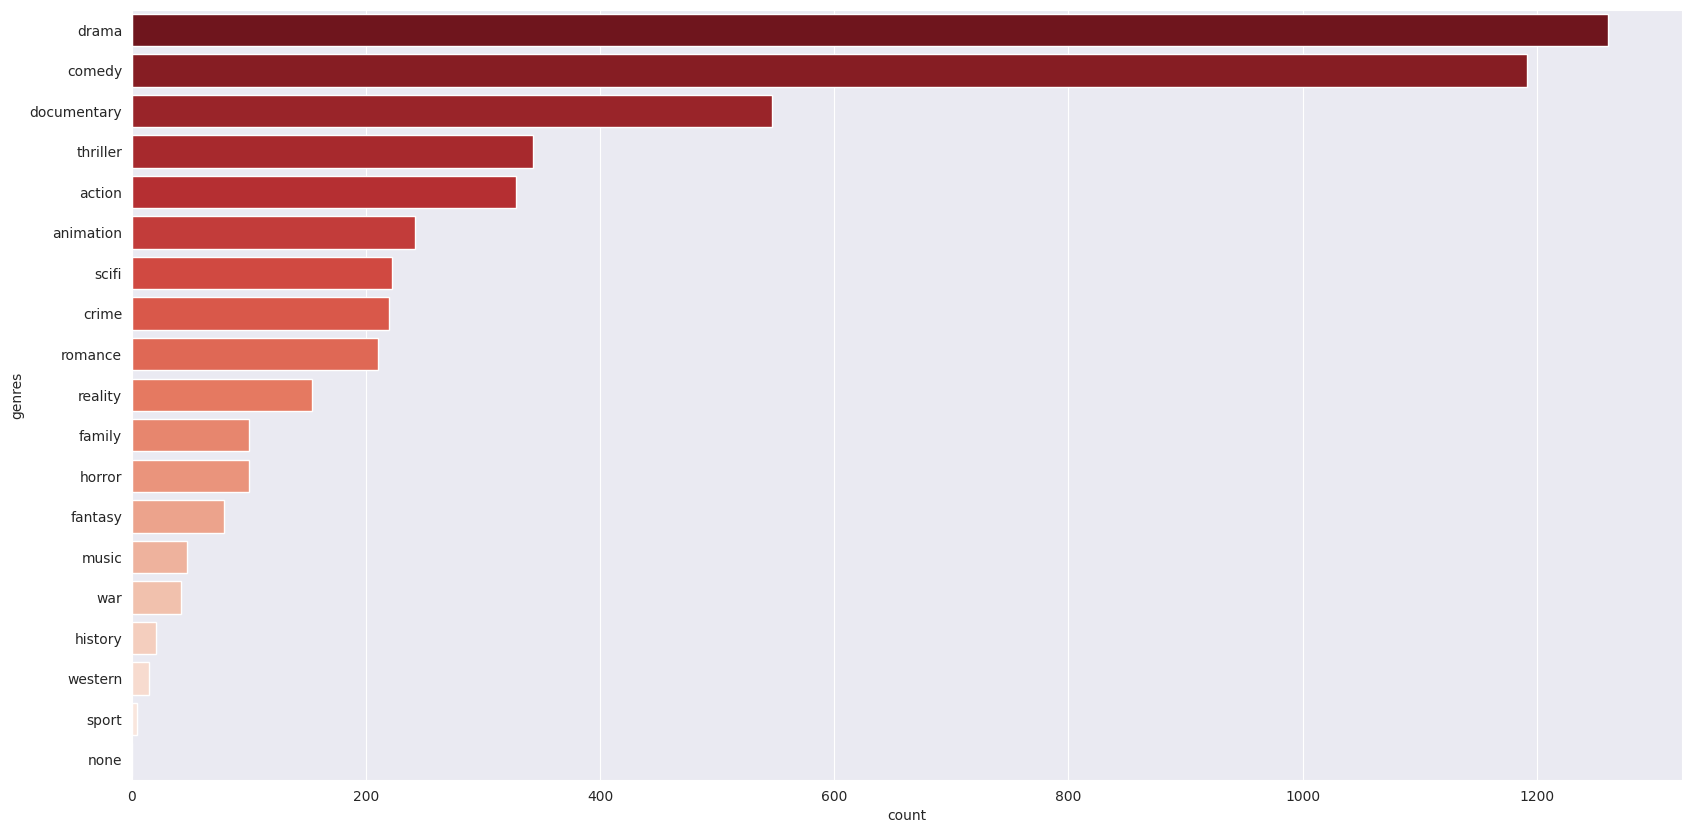

In [ ]:
#Distribution of Genres
df['genres'].replace(to_replace='documentation', value='documentary', inplace=True)
filtered_df = df[df['genres'] != 'none']
plt.figure(figsize=(20,10))
sns.countplot(data=filtered_df, y='genres', palette='Reds_r', order=df['genres'].value_counts().index)

In [ ]:
drama_df = df[df['genres'] == 'drama']
comedy_df = df[df['genres'] == 'comedy']
doc_df = df[df['genres'] == 'documentary']
drama_count = drama_df['title'].count()
comedy_count = comedy_df['title'].count()
doc_count = doc_df['title'].count()
print(drama_count)
print(comedy_count)
print(doc_count)

1261
1192
547


Text(0.5, 1.0, 'Total Released Content by Year')

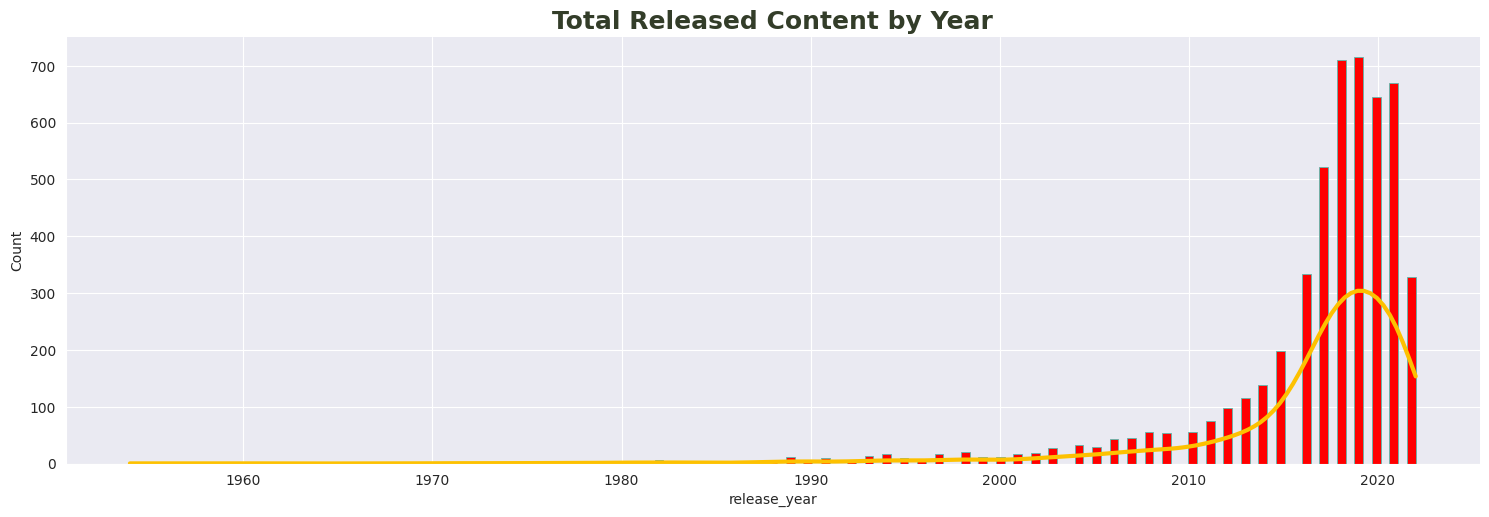

In [ ]:
# Amount of movies based on release_year
sns.displot(data=df, x='release_year', kind='hist', kde=True,
color='#fdc100', facecolor='red', edgecolor='#64b6ac', line_kws={'lw': 3}, aspect=3)
plt.title('Total Released Content by Year', fontsize=18, weight=600, color='#333d29')

In [ ]:
max_df = df[df['release_year'] == 2019]
max_count = max_df['title'].count()
print(max_count)

715


In [ ]:
# Get the minimum release year
min_release_year = df['release_year'].min()
print(min_release_year)
min_df = df[df['release_year'] == 1954]
min_count = min_df['title'].count()
print(min_count)

1954
2


#Data Analytics Techniques: Natural Language Processing


In [ ]:
df2 = df.copy()
df2 = df[df["type"] == "MOVIE"].reset_index(drop=True)
df2.shape

In [ ]:
#Defining NLP functions
#Function to remove punctuation
def remove_punc(text):
text = text.translate(str.maketrans('', '', string.punctuation))
return text
#Function to remove all capitalizations
def go_lower(text):
text = text.lower()
return text
#Function to clean and remove all emojis, special characters etc
from cleantext import clean
def no_emoji(text):
clean_text = clean(text, no_emoji = True)
return clean_text

In [ ]:
#Function implementation (con't)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
# Function to remove stopwords
def remove_stops(text):
stop_words = set(stopwords.words("english"))
word_tokens = word_tokenize(text)
filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
filtered_sentence_str = ' '.join(filtered_sentence)
return filtered_sentence_str
#Function to tokenize
def tokenizer(text):
tokens = word_tokenize(text)
return tokens
#Function to lemmatize
def lemmas(tokens):
lemmatizer = WordNetLemmatizer()
lemmatized = []
for token in tokens:
lemma_word = lemmatizer.lemmatize(token)
lemmatized.append(lemma_word)
return lemmatized
# Function to convert list of tokens to one string of words
def list_to_string(data):
data = " ".join(data)
return data

In [ ]:
# Applying NLP Algorithm
df2["description"] = df2["description"].apply(no_emoji)
df2["description"] = df2["description"].apply(go_lower)
df2["description"] = df2["description"].apply(remove_punc)
df2["description"] = df2["description"].apply(remove_stops)
df2.head(3)

# Intuition behind TF-IDF Vectorizer

We take the  movie plot, cleaning them through some NLP techniques and then creating a TFIDF vectors for each plot. Then we get a huge TFIDF matrix from all the movie plots.

The TFIDF is a term frequency that counts the number of times each word shows up in the description. But it goes one step further and decreases the importance of highly frequent words in the description. If a word like 'earth' occurs very frequently in many movie plots then it really does not have that much weight and importance. On the other side a word like "Hobbit" is a word occuring in very few movies and hence any movies with the word "Hobbit" in the plot would generate a very high tfidf score

Based on the frequency of each word and the relative importance of the word the TFIDF is calculated and the scores can be structured as vectors





In [ ]:
# Creating TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
# Create TFIDF object instance
tfidf = TfidfVectorizer()
# Generate the tfidf matrix from the plot descriptions
tfidf_matrix = tfidf.fit_transform(df2["description"])
# Compute the cosine similarity matrix
cosine_sim_tfidf = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
# Recommendation system: Based on the description, what movie/show is most similar?
# Create a simple function to extract the necessary info needed from our original dataframe
def get_df_info(df,_column, _index):
info = df[_column][_index]
return info
def recommendation_engine(movie_title, cosine_similar):
recommended_movies = []
movie_desc_list = []
imdb_ids = []
streaming_platform_list = []
cost_list = []
imdb_score_list = []
# Obtain the index of our movie title
index = df[df['title'] == movie_title].index[0]
# Sort through our cosine similarity matrix and find the top 10 values for this specific movie title index
similarity_score = pd.Series(cosine_similar[index]).sort_values(ascending=False)
# Get index of these films
top_10_content = (similarity_score.iloc[1:11].index)
# Create a tuple for each film, we use the get_df_info function for ease of use
movie_data = [(get_df_info(df,'title',i), get_df_info(df,'type',i), get_df_info(df,'description',i), get_df_info(df,'release_year',i),
get_df_info(df,'imdb_score',i), get_df_info(df,'imdb_votes',i)) for i in top_10_content if get_df_info(df,'title',i) != movie_title]
# Append to our empty lists
recommended_movies = [m[0] for m in movie_data]
content_type = [m[1] for m in movie_data]
description = [m[2] for m in movie_data]
release_year = [m[3] for m in movie_data]
imdb_score = [m[4] for m in movie_data]
imdb_votes = [m[5] for m in movie_data]
# Arrange them in a dictionary
recommended_dict = {'Title': recommended_movies, "Type": content_type,"Description":  description,
"Release Year": release_year, "imdb_scores": imdb_score,"imdb_votes": imdb_votes}
recommended_df = pd.DataFrame.from_dict(recommended_dict)
# Note that sometimes the same content is avilable in multiple streaming services, so we will do a groupby and show all the availabilities
if recommended_df["Title"].duplicated().sum() > 0:
recommended_df  = recommended_df.groupby("Movie Name",as_index = False,sort = False).agg({"release_year":lambda x: ", ".join([i for i in x]),
"imdb_score": lambda y: ", ".join([j for j in y]),
"Plot": 'first', "type":'first', "desctiption": 'max'})
return recommended_df

In [ ]:
# What happens if we use the Movie 'Taxi Driver' as the recommendation
# Withdrew the tmdb_votes/scores for readability
recommendation_engine("Taxi Driver", cosine_sim_tfidf)

In [ ]:
# What happens if we use the Movie 'NCIS' as the recommendation
# Withdrew the tmdb_votes/scores for readability
recommendation_engine("NCIS", cosine_sim_tfidf)

In [ ]:
# Results:
# It is hard to say if these movie/shows are genuinely alike to Taxi Driver, simply based on the description.
#Limitations:
# Time
# With more time, we can invest more into the project -- working on a time crunch
# Computing Power
# Large datasets and larger recommendation models require more computing power/RAM
# Learning Curve
# One-hot encoding the genres
# Working with recommendation models
# Normalizing the votes
# In the future:
# A hybrid model may work to include the scores and genres as well
# Possibly by working to one-hot encode the genres
# Upskilling in NLP may benefit when making recommendation models
# We would also like to investigate the possibility of developing a predictive model that can determine
# the popularity of a TV show or movie onNetflixbased on various features such as its genre, rating,
# country of production and othe relevant factors.